# Problem Set 7: Building ConvNets with PyTorch

**Release Date:** 02 November 2023

**Due Date:** 2359h, 11 November 2023

In PS6, you looked at the basics of building learning pipelines with `PyTorch`. Computer Vision, the field that aims to make computers understand and learn visual objects like images, is a hot topic in Machine Learning. Knowledge of building these Computer Vision pipelines is pertinent given the fast-paced nature of the field.

<img src="imgs/logo.png" width="600">

In *Problem Set 7*, we will take you through data `PyTorch` API for Computer Vision. You will be building a __Convolutional Neural Network__ (CNN/ConvNet) and training it on two datasets, *MNIST* and *CIFAR-10*. You'll also learn how to build __data augmentation pipelines__ to enhance your dataset. Finally, you'll look through the eyes of your ConvNet to see __why__ it's making certain predictions.

In [13]:
# do not remove this cell
# run this cell before moving on

# DL libraries
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torchvision import datasets, transforms

# Computational libraries
import math
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Chapter 1: Vision Layers

Here, you'll be building the two fundamental layers that are the cornerstone of Computer Vision: the convolutional layer and the pooling layer (specifically, __max__ pooling). 

## Task 1.1: Convolution Under The Hood

Your task is to write the `conv2d` function that performs the convolution operation on a 2-dim image, `img : torch.Tensor`, using a certain kernel, `kernel : torch.Tensor`. Assume there is no padding and the stride is 1. 

> Don't work on the channels – assume they remain the same. Your code should only work on the spatial dimensions: Height and Width.

We've given you two images `x1` and `x2` and their convolutional outputs `c1` and `c2` respectively. Run them to verify whether your function is working as expected.

$$
c1 = \texttt{conv2d}\Bigg(
\begin{bmatrix}
    4 & 9 & 3 & 0 & 3 \\
    9 & 7 & 3 & 7 & 3 \\
    1 & 6 & 6 & 9 & 8 \\
    6 & 6 & 8 & 4 & 3 \\
    6 & 9 & 1 & 4 & 4 \\
\end{bmatrix},~
\begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}\Bigg) = 
    \begin{bmatrix} 
        4+9+9+7 & 9+3+7+3 & 3+0+3+7 & 0+3+7+3 \\
        9+7+1+6 & 7+3+6+6 & 3+7+6+9 & 7+3+9+8  \\
        1+6+6+6 & 6+6+6+8 & 6+9+8+4 & 9+8+4+3 \\
        6+6+6+9 & 6+8+9+1 & 8+4+1+4 & 4+3+4+4 \\
    \end{bmatrix} =
\begin{bmatrix} 
        29 & 22 & 13 & 13 \\
        23 & 22 & 25 & 27  \\
        19 & 26 & 27 & 24 \\
        27 & 24 & 17 & 15 \\
\end{bmatrix}
$$

$$
c2 = \texttt{conv2d}\Bigg(
\begin{bmatrix}
    1 & 9 & 9 & 9 & 0 & 1 \\
    2 & 3 & 0 & 5 & 5 & 2 \\
    9 & 1 & 8 & 8 & 3 & 6 \\
    9 & 1 & 7 & 3 & 5 & 2 \\
    1 & 0 & 9 & 3 & 1 & 1 \\
    0 & 3 & 6 & 6 & 7 & 9 \\
\end{bmatrix},~
\begin{bmatrix}
    6 & 3 & 4 & 5 \\
    0 & 8 & 2 & 8 \\
    2 & 7 & 5 & 0 \\
    0 & 8 & 1 & 9 \\
\end{bmatrix}\Bigg) = \begin{bmatrix} 
    285 & 369 & 286 \\
    230 & 317 & 257 \\ 
    306 & 374 & 344 \\
\end{bmatrix}
$$

__Note:__ You are not allowed to use the `torch.nn.functional.conv2d` function.

In [14]:
torch.manual_seed(0)

def conv2d(img, kernel):
    """
    PARAMS
        img: the 2-dim image with a specific height and width
        kernel: a 2-dim kernel (smaller than image dimensions) that convolves the given image
    
    RETURNS
        the convolved 2-dim image
    """
    img_height, img_width = img.shape
    kernel_height, kernel_width = kernel.shape
    output_height = img_height - kernel_height + 1
    output_width = img_width - kernel_width + 1
    output = torch.zeros((output_height, output_width))
    
    for i in range(output_height):
        for j in range(output_width):
            cur_window = img[i:i+kernel_height, j:j+kernel_width]
            output[i, j] = torch.sum(cur_window * kernel)
    
    
    return output

In [15]:
x1 = torch.tensor([
    [4, 9, 3, 0, 3],
    [9, 7, 3, 7, 3],
    [1, 6, 6, 9, 8],
    [6, 6, 8, 4, 3],
    [6, 9, 1, 4, 4]
])
k1 = torch.ones((2, 2))
o1 = torch.tensor([
    [29., 22., 13., 13.],
    [23., 22., 25., 27.],
    [19., 26., 27., 24.],
    [27., 24., 17., 15.]
])

x2 = torch.tensor([
    [1, 9, 9, 9, 0, 1],
    [2, 3, 0, 5, 5, 2],
    [9, 1, 8, 8, 3, 6],
    [9, 1, 7, 3, 5, 2],
    [1, 0, 9, 3, 1, 1],
    [0, 3, 6, 6, 7, 9]
])
k2 = torch.tensor([
    [6, 3, 4, 5],
    [0, 8, 2, 8],
    [2, 7, 5, 0],
    [0, 8, 1, 9]
])
o2 = torch.tensor([
    [285., 369., 286.],
    [230., 317., 257.],
    [306., 374., 344.]
])

# TEST YOUR conv2d FUNCTION HERE
c1 = conv2d(x1, k1)
print(c1, torch.all(torch.eq(c1, o1)).item())
c2 = conv2d(x2, k2)
print(c2, torch.all(torch.eq(c2, o2)).item())

tensor([[29., 22., 13., 13.],
        [23., 22., 25., 27.],
        [19., 26., 27., 24.],
        [27., 24., 17., 15.]]) True
tensor([[285., 369., 286.],
        [230., 317., 257.],
        [306., 374., 344.]]) True


## Task 1.2: Max Pooling Under The Hood

Your task is to write the `maxpool2d` function that takes in an image, `img : torch.Tensor`, and a square kernel size `size : int`. Assume stride is 1 and there's no padding.

We've given you two images `x1` and `x2` to test your `maxpool2d` function with `size=2` and `size=3` respectively.  
$$
m1 = \texttt{maxpool2d}\Bigg(
\begin{bmatrix}
    4 & 9 & 3 & 0 & 3 \\
    9 & 7 & 3 & 7 & 3 \\
    1 & 6 & 6 & 9 & 8 \\
    6 & 6 & 8 & 4 & 3 \\
    6 & 9 & 1 & 4 & 4 \\
\end{bmatrix},~2\Bigg) =
\begin{bmatrix} 
        max(4,9,9,7) & max(9,3,7,3) & max(3,0,3,7) & max(0,3,7,3) \\
        max(9,7,1,6) & max(7,3,6,6) & max(3,7,6,9) & max(7,3,9,8)  \\
        max(1,6,6,6) & max(6,6,6,8) & max(6,9,8,4) & max(9,8,4,3) \\
        max(6,6,6,9) & max(6,8,9,1) & max(8,4,1,4) & max(4,3,4,4) \\
\end{bmatrix} =
\begin{bmatrix} 
        9 & 9 & 7 & 7 \\
        9 & 7 & 9 & 9  \\
        6 & 8 & 9 & 9 \\
        9 & 9 & 8 & 4 \\
\end{bmatrix}
$$

$$
m2 = \texttt{maxpool2d}\Bigg(
\begin{bmatrix}
    1 & 9 & 9 & 9 & 0 & 1 \\
    2 & 3 & 0 & 5 & 5 & 2 \\
    9 & 1 & 8 & 8 & 3 & 6 \\
    9 & 1 & 7 & 3 & 5 & 2 \\
    1 & 0 & 9 & 3 & 1 & 1 \\
    0 & 3 & 6 & 6 & 7 & 9 \\
\end{bmatrix},~3\Bigg) = \begin{bmatrix} 
    9 & 9 & 9 & 9 \\
    9 & 8 & 8 & 8 \\ 
    9 & 9 & 9 & 8 \\
    9 & 9 & 9 & 9 \\
\end{bmatrix}
$$

__Note:__ You are not allowed to use the `torch.nn.functional.max_pool2d` function.

In [16]:
torch.manual_seed(0)

def maxpool2d(img, size):
    """
    PARAMS
        img: the 2-dim image with a specific height and width
        size: an integer corresponding to the window size for Max Pooling
    
    RETURNS
        the 2-dim output after Max Pooling
    """
    output_height = img.shape[0] - size + 1
    output_width = img.shape[1] - size + 1
    output = torch.zeros((output_height, output_width))
    for i in range(output_height):
        for j in range(output_width):
            cur_window = img[i:i+size, j:j+size]
            output[i, j] = torch.max(cur_window)
    
    return output

In [17]:
x1 = torch.tensor([
    [4, 9, 3, 0, 3],
    [9, 7, 3, 7, 3],
    [1, 6, 6, 9, 8],
    [6, 6, 8, 4, 3],
    [6, 9, 1, 4, 4]
])
k1 = 2
o1 = torch.tensor([
    [9., 9., 7., 7.],
    [9., 7., 9., 9.],
    [6., 8., 9., 9.],
    [9., 9., 8., 4.]
])

x2 = torch.tensor([
    [1, 9, 9, 9, 0, 1],
    [2, 3, 0, 5, 5, 2],
    [9, 1, 8, 8, 3, 6],
    [9, 1, 7, 3, 5, 2],
    [1, 0, 9, 3, 1, 1],
    [0, 3, 6, 6, 7, 9]
])
k2 = 3
o2 = torch.tensor([
    [9., 9., 9., 9.],
    [9., 8., 8., 8.],
    [9., 9., 9., 8.],
    [9., 9., 9., 9.]
])

# TEST YOUR maxpool2d FUNCTION HERE
m1 = maxpool2d(x1, k1)
print(m1, torch.all(torch.eq(m1, o1)).item())
m2 = maxpool2d(x2, k2)
print(m2, torch.all(torch.eq(m2, o2)).item())

tensor([[9., 9., 7., 7.],
        [9., 7., 9., 9.],
        [6., 8., 9., 9.],
        [9., 9., 8., 4.]]) True
tensor([[9., 9., 9., 9.],
        [9., 8., 8., 8.],
        [9., 9., 9., 8.],
        [9., 9., 9., 9.]]) True


# Chapter 2: MNIST Classification with CNNs

As done in PS5, we will be working on the MNIST handwritten digits classification problem. This time, however, your images are no longer flattened to form input vectors $\in \mathbb{R}^{784}$. You'll be working the images as they are in the form of $1 \times 28 \times 28$ tensors, where $28$ is the image height and width, and $1$ is the number of colour channels (grayscale image in this case).

In [18]:
# do not remove this cell
# run this before moving on

T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

"""
Note: You can update the path to point to the directory containing `MNIST` 
directory to avoid downloading the MNIST data again.
"""
mnist_train = datasets.MNIST("./", train=True, download=True, transform=T)
mnist_test = datasets.MNIST("./", train=False, download=True, transform=T)

"""
if you feel your computer can't handle too much data, you can reduce the batch
size to 64 or 32 accordingly, but it will make training slower. 

We recommend sticking to 128 but do choose an appropriate batch size that your
computer can manage. The training phase tends to require quite a bit of memory.
"""
train_loader = torch.utils.data.DataLoader(mnist_train, shuffle=True, batch_size=256)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=10000)

def get_accuracy(scores, labels):
    ''' accuracy metric '''
    _, predicted = torch.max(scores.data, 1)
    correct = (predicted == labels).sum().item()   
    return correct / scores.size(0)

In [19]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


## Concept 1: DataLoaders

PyTorch __DataLoaders__ accept datasets and can iterate through the datasets as we deem fit.

`train_loader = torch.utils.data.DataLoader(mnist_train, shuffle=True, batch_size=256)` means that this dataloader takes in the MNIST training data, and outputs training features and labels in batches of 256. It also reshuffles all the data in the dataset for the next epoch once it has outputted all the data in the dataset.

Run the following code to get a better idea of how dataloaders work.

Feature batch shape: torch.Size([256, 1, 28, 28])
Labels batch shape: torch.Size([256])


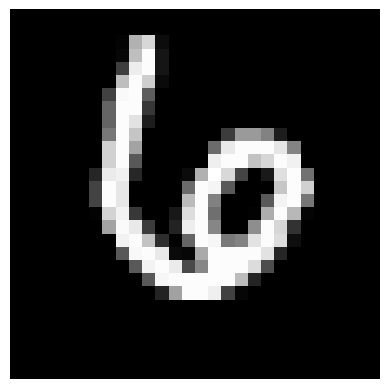

Label: 6


In [20]:
# no need to code
# run this before moving on

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()
print(f"Label: {label}")

## Task 2.1: Building a Vanilla ConvNet

Your task here is to build a ConvNet using PyTorch layers. You can refer to the attached command glossary to read more about the layers. Use the following architecture:

$$
\text{Conv(32, (3,3))} \rightarrow \text{MP(2,2)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{Conv(64, (3,3))} \rightarrow \text{MP(2,2)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{Flat} \\ \rightarrow \text{L(1600, 256)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{L(256, 128)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{L(128, 10)} \rightarrow \text{Softmax}
$$

where 
- [`Conv`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) is a Convolution layer with the specified output channels and kernel size, with no padding and a stride of 1 by default.

- [`MP`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) is the Max Pooling layer with the specified kernel size, with no padding, the stride set to the same shape as the kernel by default.

- [`LReLU`](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) is Leaky ReLU with the specified negative slope.

- `Flat` is the flattening operation, which should flatten/reshape the tensor from a multi-dimensional tensor (batch_size, num_channels, width, height) into a "flat" tensor (batch_size, num_channels x width x height). The 2-dimensional result represents that each sample has only 1 dimension of "flattened" data. This has already been implemented for you

- [`L`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is a fully-connected layer with the specified input and output features.

You are highly encouraged to initialise all your layers in the `__init__` method.

__Note:__ The only constructor argument here is `classes`. For all your networks hereon, do not add any parameters to the `__init__` method other than the ones mentioned. Remember not to hardcode for the number of classes and use the `classes` argument instead.

__Note:__ There is no need to include a Softmax layer in your neural network, as technically, [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) which we are going to use as our loss function later, already applies Softmax implicitly.

In [21]:
class RawCNN(nn.Module):
    def __init__(self, classes):
        super().__init__()
        """
        classes: integer that corresponds to the number of classes for MNIST
        """
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.l1 = nn.Linear(1600, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, classes)
        self.act = nn.LeakyReLU(0.1)
        # order:
        # conv1 -> pool1 -> act -> conv2 -> pool2 -> act -> flat -> l1 -> act -> l2 -> act -> l3
        
    def forward(self, x):
        x = self.act(self.pool1(self.conv1(x)))
        x = self.act(self.pool2(self.conv2(x)))
        x = x.view(-1, 64*5*5) # Flattening – do not remove this line
        x = self.act(self.l1(x))
        x = self.act(self.l2(x))
        x = self.l3(x)
        return x

# Test your network's forward pass
num_samples, num_channels, width, height = 20, 1, 28, 28
x = torch.rand(num_samples, num_channels, width, height)
net = RawCNN(10)
y = net(x)
print(y.shape) # torch.Size([20, 10])

torch.Size([20, 10])


## Concept 2: Dropout

__Dropout__ (*Srivastava et al., 2014*) is a regularisation technique that randomly shuts off neurons in a given layer. This means the output of the neuron is __zero__. As users, we need to specify a probability value `p` that is the probability of a neuron being shut off or not; there's a $p$ chance of a neuron being shut off.

Suppose a layer has $n$ neurons/units. Mathematically, 

$$
\text{Prob}(i = 1) = p \\
\text{Prob}(i = 0) = 1 - p
$$ 

where $i \in \{1, \dots, n\}$ and $1$ represents neuron $i$ being shut off and $0$ represents neuron $0$ left untouched.

Essentially, Dropout does this:

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-23_at_6.19.24_PM.png" width=600>

### Why Dropout works
By randomly dropping/zero-ing out neurons in a layer, it has a regularising effect on the model. It prevents overfitting because the loss of certain features means the model doesn't accidentally compute very complex functions to model the relationship between $x$ and $y$.

### Dropout in PyTorch
To use Dropout in a network, we can create a `Dropout` layer in our `__init__` method of the model class:

```python
class Model(nn.Module):
    def __init__(self, ..., drop_prob):
        super().__init__()
        self.l1 = ...
        ...
        self.dropout = nn.Dropout(p=drop_prob)
        ...
        self.ln = ...
   
    def forward(self, x):
        x = self.l1(x)
        ...
        x = self.dropout(x)
        ...
        out = ...
        
        return out
```

---

## Task 2.2: Building a ConvNet with Dropout

Here, you must build the exact same network but with Dropout inside the architecture. You can refer to the attached command glossary to read more about the layers. Use the following architecture:

$$
\text{Conv(32, (3,3))} \rightarrow \text{MP(2,2)} \rightarrow \text{LReLU(0.1)} \rightarrow \textbf{DO(0.5)} \rightarrow \\
\text{Conv(64, (3,3))} \rightarrow \text{MP(2,2)} \rightarrow \text{LReLU(0.1)} \rightarrow \textbf{DO(0.5)} \rightarrow \\
\text{Flat} \rightarrow \text{L(1600, 256)} \rightarrow \text{LReLU(0.1)} \rightarrow \textbf{DO(0.5)} \rightarrow \\
\text{L(256, 128)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{L(128, 10)} \rightarrow \text{Softmax}
$$

where 
- [`Conv`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) is a Convolution layer with the specified output channels and kernel size, with no padding and a stride of 1 by default.

- [`MP`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) is the Max Pooling layer with the specified kernel size, with no padding, the stride set to the same shape as the kernel by default.

- [`LReLU`](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) is Leaky ReLU with the specified negative slope.

- `Flat` is the flattening operation, which should flatten/reshape the tensor from a multi-dimensional tensor (batch_size, num_channels, width, height) into a "flat" tensor (batch_size, num_channels x width x height). The 2-dimensional result represents that each sample has only 1 dimension of "flattened" data. This has already been implemented for you

- [`L`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is a fully-connected layer with the specified input and output features.
 
- [`DO`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) is Dropout with the specified dropping probability.

You are highly encouraged to initialise all your layers in the `__init__` method.

__Reminder:__ Do not hardcode for the number of classes and the dropout probability. Use the `classes` and `drop_prob` constructor arguments instead.

__Note:__ There is no need to include a Softmax layer in your neural network, as technically, [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) which we are going to use as our loss function later, already applies Softmax implicitly.

In [22]:
class DropoutCNN(nn.Module):
    def __init__(self, classes, drop_prob=0.5):
        super().__init__()
        """
        classes: integer that corresponds to the number of classes for MNIST
        drop_prob: probability of dropping a node in the neural network
        """
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.l1 = nn.Linear(1600, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, classes)
        self.act = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(drop_prob)
        
        # YOUR CODE HERE
        
    def forward(self, x):
        x = self.act(self.pool1(self.conv1(x)))
        x = self.dropout(x)
        x = self.act(self.pool2(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64*5*5) # Flattening – do not remove this line
        x = self.act(self.l1(x))
        x = self.dropout(x)
        x = self.act(self.l2(x))
        x = self.l3(x)
        return x

# Test your network's forward pass
num_samples, num_channels, width, height = 20, 1, 28, 28
x = torch.rand(num_samples, num_channels, width, height)
net = DropoutCNN(10)
y = net(x)
print(y.shape) # torch.Size([20, 10])

torch.Size([20, 10])


## Task 2.3: Training your Vanilla and Dropout CNNs

Here, write down the training loop in the function `train_model` to train the CNNs you have just created. It will take in the respective NN (vanilla or dropout), as well as training and testing __data loaders__ (more on this later) that return batches of images and their respective labels to train on. 

Use the `torch.optim.Adam(...)` optimizer and Cross Entropy Loss.

> Return the model and epoch losses.

Remember to extract the loss value from the `loss` tensor by using `loss.item()`.

__Tip:__ Don't be worried if your model takes a while to train. Your mileage may also vary depending on your CPU. But if you would like to speed things up, you can consider making use of your device's GPU to parallelize the matrix computations.

In [25]:
%%time 
# do not remove the above line

def train_model(loader, model):
    """
    PARAMS
    loader: the data loader used to generate training batches
    model: the model to train
  
    RETURNS
        the final trained model 
    """

    """
    YOUR CODE HERE
    
    - create the loss and optimizer
    """
    epoch_losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    for i in range(10):
        epoch_loss = 0
        
        for idx, data in enumerate(loader):
            x, y = data

            """
            YOUR CODE HERE
            
            - reset the optimizer
            - perform forward pass
            - compute loss
            - perform backward pass
            """
            optimizer.zero_grad()
            scores = model(x)
            loss = loss_fn(scores, y)
            loss.backward()
            optimizer.step()

            # COMPUTE STATS
            epoch_loss += loss.item()

        epoch_loss = epoch_loss / len(loader)
        epoch_losses.append(epoch_loss)
        print ("Epoch: {}, Loss: {}".format(i, epoch_loss))
        
    return model, epoch_losses

vanilla_model, losses = train_model(train_loader, RawCNN(10))
do_model, losses = train_model(train_loader, DropoutCNN(10))


Epoch: 0, Loss: 0.27276542465737524
Epoch: 1, Loss: 0.05876163946900596
Epoch: 2, Loss: 0.03852760342564038
Epoch: 3, Loss: 0.027975154351046746
Epoch: 4, Loss: 0.020959025261765147
Epoch: 5, Loss: 0.018622298652375552
Epoch: 6, Loss: 0.01422767517468991
Epoch: 7, Loss: 0.011373897698618709
Epoch: 8, Loss: 0.009110355694181326
Epoch: 9, Loss: 0.008336458205396528
Epoch: 0, Loss: 0.46655385919073794
Epoch: 1, Loss: 0.13140899174390955
Epoch: 2, Loss: 0.10095435266799115
Epoch: 3, Loss: 0.08462690489881851
Epoch: 4, Loss: 0.07849364940948943
Epoch: 5, Loss: 0.07283653959711181
Epoch: 6, Loss: 0.0674034548328912
Epoch: 7, Loss: 0.062031452880894886
Epoch: 8, Loss: 0.05951128518010708
Epoch: 9, Loss: 0.0572339395734858
CPU times: user 40min 20s, sys: 18min 4s, total: 58min 25s
Wall time: 11min 37s


In [26]:
# do not remove – nothing to code here
# run this cell before moving on

with torch.no_grad():
    vanilla_model.eval()
    for i, data in enumerate(test_loader):
        x, y = data
        pred_vanilla = vanilla_model(x)
        acc = get_accuracy(pred_vanilla, y)
        print(f"vanilla acc: {acc}")
        
    do_model.eval()
    for i, data in enumerate(test_loader):
        x, y = data
        pred_do = do_model(x)
        acc = get_accuracy(pred_do, y)
        print(f"drop-out (0.5) acc: {acc}")
        
"""
The network with Dropout might under- or outperform the network without
Dropout. However, in terms of generalisation, we are assured that the Dropout
network will not overfit – that's the guarantee of Dropout.

A very nifty trick indeed!
"""

vanilla acc: 0.9909
drop-out (0.5) acc: 0.9923


"\nThe network with Dropout might under- or outperform the network without\nDropout. However, in terms of generalisation, we are assured that the Dropout\nnetwork will not overfit – that's the guarantee of Dropout.\n\nA very nifty trick indeed!\n"

## Task 2.4: Observing Effects of Dropout

Here, train your `DropoutCNN` with your `train_model(loader, model)` from Task 2.3, but with `p=0.1` and `p=0.95` respectively. 

Explain why extreme values of Dropout don't work as well on neural networks. Look back at first principles – what does Dropout do in the first place? How does the `p` value affect how it does it? 

In [27]:
%%time 
# do not remove – nothing to code here
# run this before moving on

do10_model, do10_losses = train_model(train_loader, DropoutCNN(10, 0.10))
do95_model, do95_losses = train_model(train_loader, DropoutCNN(10, 0.95))

Epoch: 0, Loss: 0.2878826161489842
Epoch: 1, Loss: 0.06368076321768
Epoch: 2, Loss: 0.043607882360749424
Epoch: 3, Loss: 0.03378436862629779
Epoch: 4, Loss: 0.029070893455138233
Epoch: 5, Loss: 0.022466007217348732
Epoch: 6, Loss: 0.019160552224406893
Epoch: 7, Loss: 0.01687588202519382
Epoch: 8, Loss: 0.013664301227966443
Epoch: 9, Loss: 0.014720652685649297
Epoch: 0, Loss: 2.3862149299459254
Epoch: 1, Loss: 2.282327202533154
Epoch: 2, Loss: 2.0824565649032594
Epoch: 3, Loss: 1.725246808376718
Epoch: 4, Loss: 1.5452551547517168
Epoch: 5, Loss: 1.4546948701777356
Epoch: 6, Loss: 1.3897098551405238
Epoch: 7, Loss: 1.352211072597098
Epoch: 8, Loss: 1.3152744308431097
Epoch: 9, Loss: 1.2899336124988312
CPU times: user 42min 35s, sys: 19min 4s, total: 1h 1min 39s
Wall time: 9min 26s


In [28]:
# do not remove – nothing to code here
# run this cell before moving on

with torch.no_grad():
    do10_model.eval()
    for i, data in enumerate(test_loader):
        x, y = data
        pred_do = do10_model(x)
        acc = get_accuracy(pred_do, y)
        print(acc)

    do95_model.eval()
    for i, data in enumerate(test_loader):
        x, y = data
        pred_do = do95_model(x)
        acc = get_accuracy(pred_do, y)
        print(acc)

0.9932
0.598


## Concept 3: Confusion Matrix Analysis

A __Confusion Matrix__ (CM) is a $k \times k$ matrix that represents the number of correctly classified and misclassified samples from the dataset. For a binary classification problem, the CM is simply $2 \times 2$. 

> For every non-diagonal row $i$ and non-diagonal column $j$, the entry $CM(i, j)$ represents the number of times the model classified a sample with label $j$ as $i$ (for example, calling a `cat` a `dog` or vice versa). 

#### TP, FP, TN, FN
Let's start small: to understand a $2 \times 2$ CM and its 4 quadrants, you need to first understand the following concepts:

- __True Positive__: when the prediction is positive and label is positive
- __True Negative__: when the prediction is negative and label is negative
- __False Positive__: when the prediction is positive and label is negative (also known as Type I error)
- __False Negative__: when the prediction is negative but label is positive (also known as Type II error)

<img src="imgs/confusion_matrix.png" width=600>

---

#### Types of Errors
__Type 1 Error__: When you support and make the __False Positive__ conclusion. Eg: The ART says you have COVID but you actually don't have it.

__Type 2 Error__: When you support and make the __False Negative__ conclusion. Eg: The ART says you don't have COVID but you actually have it. 

Obviously, we want the model to score high on the True Positives and True Negatives (i.e., the diagonals). Here's a comic to better understand the above terms:

<img src="imgs/doc_confusion_matrix.png" width=500>

---

This concept of FP, TP, FN, TN and the confusion matrix can be scaled to a classification problem with $k > 2$ classes as well. The diagonals represent the number of samples the model correctly classified where each column (or row) corresponds to class label (or prediction). 

## Task 2.5: What did the model misclassify?

Your task is to run the cell below, and check out the CM for the vanilla model and dropout model you have previously trained in Task 2.3. On Coursemology, post a screenshot of the two CMs, identify which class (i.e., which digit) each model misclassified the most (the class with the most **False Positives + False Negatives**), and explain your reasoning on how you came to this conclusion for both models.

vanilla acc: 0.9909
drop-out (0.5) acc: 0.9923


<AxesSubplot:title={'center':'Confusion Matrix for do_model'}>

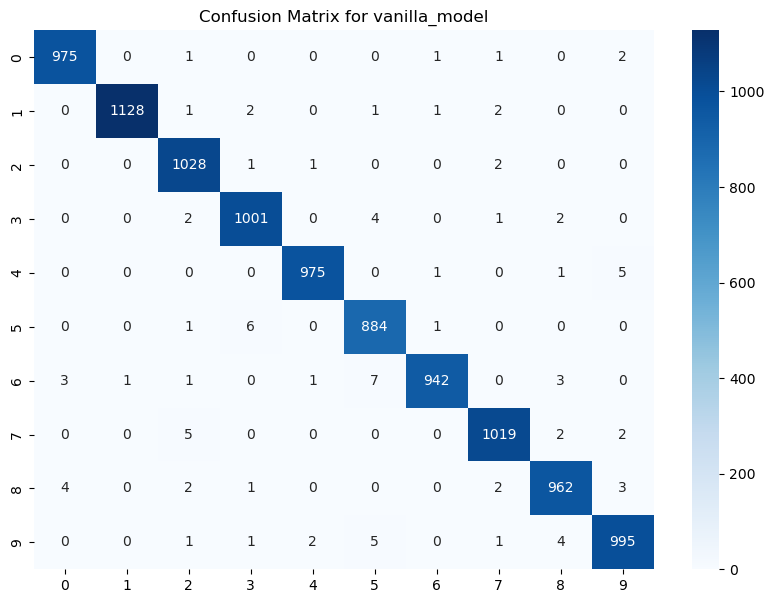

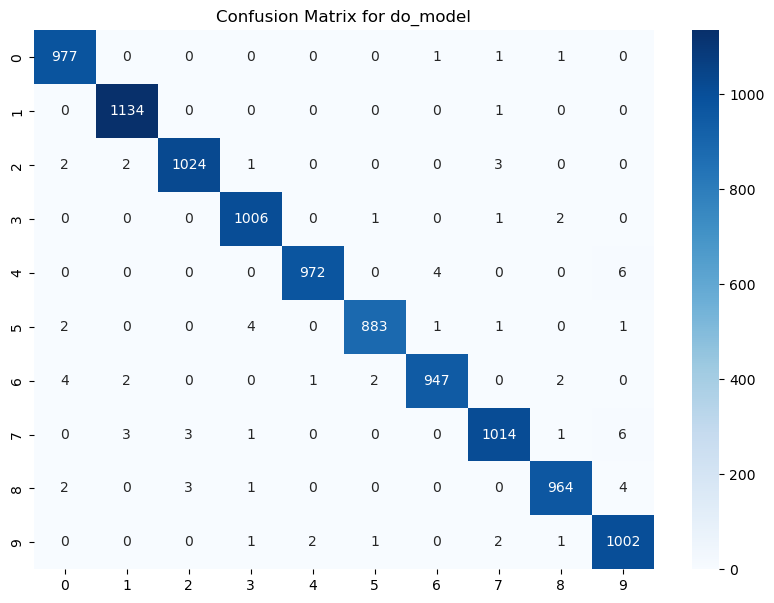

In [29]:
from sklearn.metrics import confusion_matrix

with torch.no_grad():
    vanilla_model.eval()
    for i, data in enumerate(test_loader):
        x, y = data
        pred_vanilla = vanilla_model(x)
        acc = get_accuracy(pred_vanilla, y)
        print(f"vanilla acc: {acc}")
        
    do_model.eval()
    for i, data in enumerate(test_loader):
        x, y = data
        pred_do = do_model(x)
        acc = get_accuracy(pred_do, y)
        print(f"drop-out (0.5) acc: {acc}")

cm = confusion_matrix(mnist_test.targets, pred_vanilla.argmax(dim=1))
plt.figure(figsize=(10,7))
plt.title('Confusion Matrix for vanilla_model')
# np.fill_diagonal(cm, 0) # you can zero-out the diagonal to highlight the errors better
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
# print(cm) # if seaborn does not work, you can always print out the array
    
cm = confusion_matrix(mnist_test.targets, pred_do.argmax(dim=1))
plt.figure(figsize=(10,7))
plt.title('Confusion Matrix for do_model')
# np.fill_diagonal(cm, 0) # you can zero-out the diagonal to highlight the errors better
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
# print(cm) # if seaborn does not work, you can always print out the array

## Concept 4: Classification Metrics (Precision, Recall, F1-score, ROC Curve, and AUC-ROC)

### Introduction

In classification tasks, we often want to evaluate the performance of our predictive model beyond just the accuracy. In some cases, we would like to minimize the number of false positives, while in other cases, we would like to minimize the number of false negatives. 

For instance, in a cancer diagnosis task, we would like to minimize the number of false negatives (i.e., patients who have cancer but are diagnosed as healthy), but don't care as much for the number of false positives (i.e., patients who don't have cancer but are diagnosed as ill) because delaying cancer treatment is dangerous while suggesting a person to go through more advanced checkup poses no additional harm. On the other hand, in a spam detection task, we would like to minimize the number of false positives (i.e., emails that are not spam but are classified as spam), because users may miss out on an important email. 

In this section, we will delve deeper into the metrics that help us to understand how well our model is doing in different aspects: Precision, Recall, F1-score, ROC Curve, and AUC-ROC.

### Definitions

#### 1. __Precision__

Precision helps us to understand the correctness of our model in predicting the positive class.

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

#### 2. __Recall__

Recall, also known as sensitivity or true positive rate, indicates how well the model identifies positive instances.

$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

#### 3. __F1-score__

The F1-score is the harmonic mean of precision and recall and provides a balance between the two metrics.

$$
\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

### Graphical Metrics

#### 4. __ROC Curve__

The ROC (Receiver Operating Characteristic) curve is a graphical representation of the true positive rate against the false positive rate, helping to visualize the performance of the binary classification model.

#### 5. __AUC-ROC__

AUC (Area Under the ROC Curve) represents the model's ability to discriminate between positive and negative classes; a higher AUC value indicates a better model performance.


<img src="imgs/Roc_curve.png" width=500>

### Further Reading
You can read more about the metrics and how to use them in the following links:
1. [Scikit-learn Classification Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)
2. [Understanding Confusion Matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

### Evaluate your model

Run the cell below to evaluate the model you built previously with the metrics.

In [30]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(f1_score(pred_do.argmax(dim=1), mnist_test.targets, average='macro'))
print(precision_score(pred_do.argmax(dim=1), mnist_test.targets, average='macro'))
print(recall_score(pred_do.argmax(dim=1), mnist_test.targets, average='macro'))

0.9922522749562231
0.9921766964595374
0.9923446376393488


# Chapter 3: Training on CIFAR-10

## Concept 5: CIFAR-10
Using what you've learned with MNIST, apply the techniques to CIFAR-10, a dataset of 60K training and 10K testing images comprising of real-life objects corresponding to the following 10 classes:

- airplane										
- automobile										
- bird										
- cat										
- deer										
- dog										
- frog										
- horse										
- ship										
- truck

Each image is $3 \times 32 \times 32$, meaning we operate on 3 color channels RGB. Some of these images look like so:

<img src="imgs/cifar.jpg" width=600>

## Concept 6: Data Augmentation

In reality, however, finding a well-representative, balanced dataset is difficult. To address this issue, we use __Data Augmentation__. It refers to the process of transforming data in a training dataset in one or more ways to create more samples to expand the training dataset. 

Here, we will pick images from the original dataset `x_train`, perform some transformations $F$ on them, and append them to `x_train`. So, for example, if I have a training dataset of 200 car images, I can perform augmentations on the 200 images to get 300 more images, thereby making my new training dataset 500 images large.

Of course, the impact of data augmentation on model training depends on the types of augmentation used. Here are some common ones Computer Vision practitioners use:

- Normalisation
- Horizontal and Vertical Flipping
- Rotation
- Blurring
- Adding noise
- Skewing
- Cropping (zooming in or out)
- Brightness and Contrast
- Shuffling pixels

This results in a wide variety of new samples being created that can be used for training.

## The `transforms` module

Here, we are going to use the `transforms` module from PyTorch to transform the images in our dataset. It contains all kinds of image transformations from `rotate` to `resize`. Check out the full list of augmentations on the PyTorch documentation: https://pytorch.org/vision/stable/transforms.html.

Explore the following example to see how the transformations work.

100.0%


Extracting ./cifar-10-python.tar.gz to ./


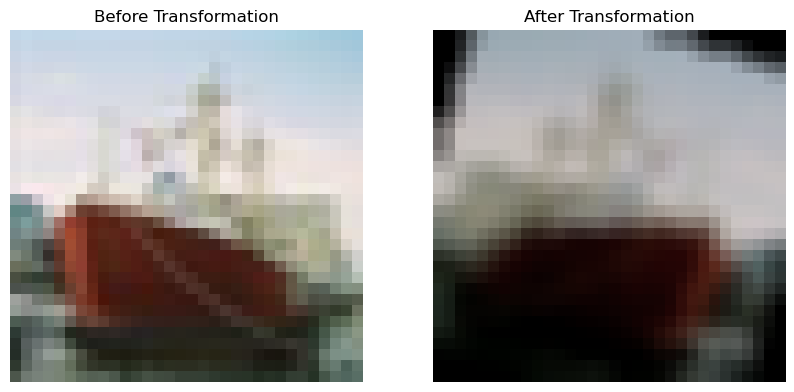

In [31]:
cifar_train = datasets.CIFAR10("./", train=True, download=True, transform=transforms.ToTensor())
cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=True)

train_features, train_labels = next(iter(cifar_train_loader))
img = train_features[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(20),
                                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
                                ]) # add in your own transformations to test
tensor_img = transform(img)
ax1.imshow(img.permute(1,2,0))
ax1.axis("off")
ax1.set_title("Before Transformation")
ax2.imshow(tensor_img.permute(1, 2, 0))
ax2.axis("off")
ax2.set_title("After Transformation")
plt.show()

## Task 3.1: Picking Data Augmentations

Your task is to pick your favourite data augmentations and apply them to the images from the dataset (in the later cell). 

We've already started you off with the necessary one `ToTensor()` that converts the original JPEG-format image to the PyTorch `Tensor` format. Refer to the command glossary to add your custom data augmentations from the list we've provided. 

**Choose at least 2 additional augmentations.** Tell us which augmentations you chose to use _and_ why. Then tell us which augmentations you avoided _and_ why. 

__Note:__ Feel free to use any augmentations you wish from the full list of augmentations shown on the [PyTorch documentation](https://pytorch.org/vision/stable/transforms.html)! There's no need to be restricted to the list that we've provided.

The point is to improve your model performance as much as possible! Use trial and error to get the best performing network in Task 3.2!

Be creative :D

__Note:__ Do ensure your augmentations retain the 3-dimensional shape of the CIFAR-10 images. The final images should still have the shape `(3, 32, 32)`.

In [ ]:
# pick your data augmentations here
def get_augmentations():
    T = transforms.Compose([
        transforms.ToTensor(),
        # YOUR CODE HERE – add more augmentations! Be creative :D
    ])
    
    return T

Create your data loaders that return batches of data:

In [ ]:
# do not remove this cell
# run this before moving on

T = get_augmentations()

cifar_train = datasets.CIFAR10("./", train=True, download=True, transform=T)
cifar_test = datasets.CIFAR10("./", train=False, download=True, transform=T)

"""
if you feel your computer can't handle too much data, you can reduce the batch
size to 64 or 32 accordingly, but it will make training slower. 

We recommend sticking to 128 but dochoose an appropriate batch size that your
computer can manage. The training phase tends to require quite a bit of memory.

CIFAR-10 images have dimensions 3x32x32, while MNIST is 1x28x28
"""
cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=True)
cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=10000)

## Concept 7: Sequential Model Building with PyTorch

All this while, you've been adding layers one by one as attributes inside the `__init__` method. This is so that you can quickly debug which layer(s) is causing issues later down the road. However, for the most part, there should be no major issues when creating parts of your network or your entire network. 

This is why PyTorch lets you combine layers together using the `nn.Sequential` API. It allows you to stack layers inside and chain layers together. It allows you to build isolated modules that can exist on their own (either within a `nn.Module` class or otherwise) and be used as independent "mini models" on data tensors. Refer to https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html for more information about combining PyTorch modules to create your own.

__Note:__ You should not add an array of layers inside `nn.Sequential` i.e., it's `nn.Sequential(xyz, abc, mno)`, **not** `nn.Sequential([xyz, abc, mno])`.

#### DEMO 1: 3-layer Multilayer Perceptron for MNIST

In [ ]:
densenet = nn.Sequential(
                nn.Linear(784, 512),
                nn.ReLU(),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Linear(128, 10),
                nn.Softmax(1) # softmax dimension
            )

x = torch.rand(15, 784) # a batch of 15 MNIST images
y = densenet(x) # here we simply run the sequential densenet on the `x` tensor
print(y.shape) # a batch of 15 predictions

#### DEMO 2: 2-layer ConvNet for MNIST

In [ ]:
convnet = nn.Sequential(
                nn.Conv2d(1, 32, (3,3)),
                nn.ReLU(),
                nn.Conv2d(32, 64, (3,3)),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(36864, 1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Linear(128, 10),
                nn.Softmax(1) # softmax dimension
            )

x = torch.rand(15, 1, 28, 28) # a batch of 15 MNIST images
y = convnet(x) # here we simply run the sequential convnet on the `x` tensor
print (y.shape) # a batch of 15 predictions

## Task 3.2: Build a ConvNet for CIFAR-10

Your task is to build a decently-sized ConvNet (i.e., $\geq 4$ layers). Design your ConvNet with the following architecture

$$
\text{Conv(32, (3,3))} \rightarrow \text{MP((2,2))} \rightarrow \text{LReLU(0.1)} \rightarrow \text{Conv(64, (3,3))} \rightarrow \text{MP((2,2))} \rightarrow \text{LReLU(0.1)} \rightarrow \text{GAP} \\ \rightarrow \text{L(64, 256)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{L(256, 128)} \rightarrow \text{LReLU(0.1)} \rightarrow \text{L(128, 10)}
$$

where 
- [`Conv`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) is a Convolution layer with the specified output channels and kernel size

- [`MP`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) is the Max Pooling layer with the specified kernel size

- [`LReLU`](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) is Leaky ReLU with the specified negative slope

- `GAP` is the Global Average Pooling operation (already implemented for you)

- [`L`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is a fully-connected layer with the specified input and output features

You are highly encouraged to initialise all your layers in the `__init__` method.

---

You must use the [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) API to build two parts:
1. The `self.conv` attribute must contain all the Convolutional, Pooling, and Activation layers
2. The `self.fc` attribute must contain all the fully-connected layers after the flattening

The `self.conv` and `self.fc` attributes are already given to you. All you need to do is chain the arbitrary `nn.XYZ` layers together based on the architecture stated above.

__Note:__ The flattening is already done for you via Global Average Pooling (GAP) in the `forward` method. Do not add the Softmax activation in the `self.fc` Sequential module.

__Reminder:__ Do not hardcode for the number of classes. Use the `classes` argument instead.

__Note:__ There is no need to include a Softmax layer in your neural network, as technically, [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) which we are going to use as our loss function later, already applies Softmax implicitly.

In [ ]:
class CIFARCNN(nn.Module):
    def __init__(self, classes):
        super().__init__()
        """
        classes: integer that corresponds to the number of classes for CIFAR-10
        """
        self.conv = nn.Sequential(
                        # YOUR CODE HERE
                    )

        self.fc = nn.Sequential(
                        # YOUR CODE HERE
                    )
        
    def forward(self, x):
        # YOUR CODE HERE

        x = x.view(x.shape[0], 64, 6*6).mean(2) # GAP – do not remove this line
        
        # YOUR CODE HERE
        
        pass

## Train your ConvNet on CIFAR-10

In [ ]:
%%time
# do not remove – nothing to code here
# run this cell before moving on

cifar10_model, losses = train_model(cifar_train_loader, CIFARCNN(10))

## Test the CIFAR-10 ConvNet model using the testing data loader

In [ ]:
# do not remove – nothing to code here
# run this cell before moving on

with torch.no_grad():
    cifar10_model.eval()
    for i, data in enumerate(cifar_test_loader):
        x, y = data
        pred = cifar10_model(x)
        acc = get_accuracy(pred, y)
        print(f"cifar accuracy: {acc}")
        
# don't worry if the CIFAR-10 accuracy is low, it's a tough dataset to crack.
# as long as you get something shy of 50%, you should be alright!

## Concept 8: Class Activation Map (CAM) Analysis

A __Class Activation Map__ (CAM) is an analysis technique that lets one see through the eyes of the model. It ultimately answers the following question: "why is the model predicting this label for a given image". 

CAM creates a superimposable heatmap that's placed on top of the test image. This heatmap is coloured more strongly for areas the model is focusing on more than others and coloured less strongly for areas the model chooses to ignore.

For example, when a picture of a dog (left) is passed through a trained ConvNet, CAM generates a heatmap (center) that's embossed on top of the image (right). The darker (redder) the region of the heatmap, the more the model focuses on that part of the image. 

<img src="imgs/cam.png" width=700>

You can think of the model looking out for the "most interesting" parts of an image when classifying it. In fact, __Saliency__ is the measure of "interestingness" in an image. ConvNets look out for the *most salient* features/regions in an image and give out their predictions based on that. 

## Task 4.1: Building CAM for CIFAR-10

Earlier we asked you to divide your CIFAR-10 ConvNet into two parts `self.conv` and `self.fc`. You'll now understand why we did so. 

Your task is to write the `get_CAM` method that takes in,

- `feature_map`: the output of the final activation layer of the CNN. You can get this by running the image through the `self.conv` module i.e., `output = self.conv(x)`

- `weight`: the weights of the immediate first Linear layer after the flattening operation

- `class_idx`: the label index that your ConvNet outputs/predicts

### The CAM Algorithm

The first few steps of CAM are already written for you. We'll let you handle the minor implementation details of the rest of the algorithm.

1. remove the first dimension of `cam` using `torch.squeeze(...)`
2. reshape `cam` to $h \times w$
3. get the difference of `cam` and the minimum elements of `cam`
4. divide `cam` by the maximum elements of `cam`
5. clip the values of `cam` so they are within the $[0, 1]$ range

Refer to the command glossary to find the respective methods.

In [ ]:
def get_CAM(feature_map, weight, class_idx):
    """
    PARAMS
        feature_map: the output of the final pre-GAP layer in the ConvNet
        weight: the parameters of the first linear layer post-GAP
        class_idx: the final prediction label of the ConvNet
    
    RETURNS
        a CAM heatmap of the areas the ConvNet is focusing on more
    """
    
    # do not remove these lines
    size_upsample = (32, 32)
    bz, nc, h, w = feature_map.shape

    before_dot = feature_map.reshape((nc, h*w))
    cam = weight[class_idx].unsqueeze(0) @ before_dot
    
    """
    YOUR CODE HERE - perform the steps listed above
    """
    
    cam = # YOUR CODE HERE ## remove the first dimension of cam using torch.squeeze(...)
    cam = # YOUR CODE HERE ## reshape cam to h x w
    cam = # YOUR CODE HERE ## get the difference of cam and the minimum elements of cam
    cam = # YOUR CODE HERE ## divide cam by the maximum elements of cam
    cam = # YOUR CODE HERE ## clip the values of cam so they are within the [0, 1] range
    
    # here, `cam` is the final processed heatmap
    # we upsample/resize the heatmap to the original image's dimensions
    # do not remove these lines
    img = transforms.Resize(size_upsample)(cam.unsqueeze(0))
    
    return img.detach().numpy(), cam

## Task 4.2: Visualising CAM Heatmaps

Once you run the `plot_cam` method in the cell below, you'll be presented two images: the original test image `x`, the raw heatmap and the image with the heatmap on it. 

Take a screenshot of all three plots and post it on Coursemology. Then, explain what you think the ConvNet was looking at that convinced the model to predict that class. Talk about this in terms of the "saliency" of the image. 

__Note:__ This is an open-ended question that tests your understanding of saliency and what features ConvNets rely on when predicting a class label. Also, the resolution of images from CIFAR-10 isn't fantastic, try your best to identify discerning features of the image!

In [ ]:
# do not remove this cell
# run this cell before moving on

cifar10_classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

def plot_cam(img, cam):
    ''' Visualization function '''
    img = img.permute(1, 2, 0)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,7))
    ax1.imshow(img)
    ax1.set_title(f"Input image\nLabel: {cifar10_classes[y]}")

    ax2.imshow(cam.reshape(32, 32), cmap="jet")
    ax2.set_title("Raw CAM.")

    ax3.imshow(img)
    ax3.imshow(cam.reshape(32, 32), cmap="jet", alpha=0.2)
    ax3.set_title(f"Overlayed CAM.\nPrediction: {cifar10_classes[idx[0]]}")
    plt.show()

In [ ]:
# do not remove this cell
# run this cell before moving on

rand_idx = torch.randint(0, 10000, size=[1]) # pick a random index from the test set

x = cifar_test[rand_idx][0] # test image
y = cifar_test[rand_idx][1] # associated test label

cifar10_model.eval()
scores = cifar10_model(x.unsqueeze(0)) # get the raw scores
probs = scores.data.squeeze()
probs, idx = probs.sort(0, True)

print('true class: ', cifar10_classes[y])
print('predicated class: ', cifar10_classes[idx[0]])

assert y == idx[0], "We want to visualize what the model is focusing on for a correct prediction, run again for another random sample!"

# if the printed prediction and label are different, it means the model misclassified it. 
# Rerun this cell until you get the same class printed for both. It will help for the visualisation later.

# Get the first Linear layer's weights and final Feature Map
params = list(cifar10_model.fc.parameters()) # access the model layers
weight = params[0].data # grab the first layer's weights

feature_maps = cifar10_model.conv(x.unsqueeze(0))

# Creating the heatmap
heatmap, _ = get_CAM(feature_maps, weight, idx[0])
    
plot_cam(x, heatmap)
# Red "hot" areas represent where the model is focusing on more
# if the shading isn't that great, rerun the cell to get another random sample

# Submission

Once you are done, please submit your work to Coursemology, by copying the right snippets of code into the corresponding box that says __Your answer__ and click __Save__. After you save, you can make changes to your
submission.

Once you are satisfied with what you have uploaded, click __Finalize submission__.  


__Note:__ Once your submission is finalized, it is considered to be submitted for grading and cannot be changed. If you need to undo this action, you will have to email your assigned tutor for help. Please do not finalize your submission until you are sure that you want to submit your solutions for grading. 